In [1]:
%reload_ext autoreload
%autoreload 2

from geometry import Cuboid, Rectangle
from model import Data
from boundary import DirichletBC, NeumannBC
from grad import PytorchPDE
from plot import plot_2D 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import vjp, vhp, jacobian, hessian

device = torch.device("cuda:0")

In [2]:
def boundary_t(x, on_boundary):
        return on_boundary and np.isclose(x[0], 0)   
def boundary_x(x, on_boundary):
        return on_boundary and (np.isclose(x[1], -1) or np.isclose(x[1], 1))
    
def func_t(x):
        return -1*torch.sin(np.pi*x[:,1])
def func_x(x):
        return x[:,0]*0

geom = Rectangle([0, -1],[1, 1])
bc_t = DirichletBC(geom, func_t, boundary_t)
bc_x = DirichletBC(geom, func_x, boundary_x)
data = Data(geom, [bc_t, bc_x], num_domain=10000, num_boundary=400, num_test=10000)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 1)

    # x represents our data
    def forward(self, x):

        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        x = torch.tanh(x)
        x = self.fc4(x)
        x = torch.tanh(x)
        output = self.fc5(x)
        return output
    
my_nn = Net()
my_nn.to(device)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
def pde(x,y,first_grads,second_grads):
    return first_grads[:,0] + y*first_grads[:,1] - (0.01/np.pi)*second_grads[:,1]

model = PytorchPDE(my_nn, data, pde, device)
model.train()

i: 1000 ; test_loss:  tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)
i: 2000 ; test_loss:  tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>)
i: 3000 ; test_loss:  tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)


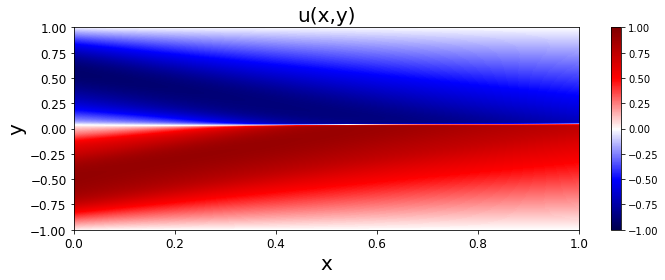

In [18]:
plot_2D(my_nn, data)